# Flow past a cylinder, transient solution from noised based flow

Resolution du probleme avec un "mixed function space" pour resoudre U et P en meme temps

# Installation et importation des librairies utiles 

In [1]:
!pip install tqdm
!pip install mpi4py
!pip install petsc4py
!pip install vtk
!pip install pyvista
!pip install pyvirtualdisplay

In [2]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

import numpy.typing
import typing

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx.cpp.mesh import to_type, cell_entity_type
from dolfinx.fem import Constant, Function, FunctionSpace, assemble_scalar, dirichletbc, form, locate_dofs_topological, set_bc
from dolfinx.fem.petsc import apply_lifting, assemble_matrix, assemble_vector, create_vector, set_bc
from dolfinx.graph import create_adjacencylist
from dolfinx.geometry import BoundingBoxTree, compute_collisions, compute_colliding_cells
from dolfinx.io import (XDMFFile, cell_perm_gmsh, distribute_entity_data, extract_gmsh_geometry,
                        extract_gmsh_topology_and_markers, ufl_mesh_from_gmsh)
from dolfinx.mesh import create_mesh, meshtags_from_entities

import ufl

from ufl import (FacetNormal, FiniteElement, Identity, Measure, TestFunction, TrialFunction, VectorElement,
                 as_vector, div, dot, ds, dx, inner, lhs, grad, nabla_grad, rhs, sym)



# Creation de la geometrie et du maillage 

In [3]:
gmsh.initialize()

L = 2.2
H = 1
c_x =0.2
c_y = 0.5
r = 0.05
gdim = 2
rank = MPI.COMM_WORLD.rank
if rank == 0:
    rectangle = gmsh.model.occ.addRectangle(0,0,0, L, H, tag=1)
    obstacle = gmsh.model.occ.addDisk(c_x, c_y, 0, r, r)

if rank == 0:
    fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
    gmsh.model.occ.synchronize()
    
fluid_marker = 1
if rank == 0:
    volumes = gmsh.model.getEntities(dim=gdim)
    gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
    gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
inflow, outflow, walls, obstacle = [], [], [], []
if rank == 0:
    boundaries = gmsh.model.getBoundary(volumes, oriented=False)
    for boundary in boundaries:
        center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
        if np.allclose(center_of_mass, [0, H/2, 0]):
            inflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L, H/2, 0]):
            outflow.append(boundary[1])
        elif np.allclose(center_of_mass, [L/2, H, 0]) or np.allclose(center_of_mass, [L/2, 0, 0]):
            walls.append(boundary[1])
        else:
            obstacle.append(boundary[1])
    gmsh.model.addPhysicalGroup(1, walls, wall_marker)
    gmsh.model.setPhysicalName(1, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
    gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
    gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
    gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
    gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
    gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

res_min = r / 3.7 #3.7
res_max = 2 * r # 1.5
if rank == 0:
    gmsh.model.mesh.field.add("Distance", 1)
    gmsh.model.mesh.field.setNumbers(1, "EdgesList", obstacle)
    gmsh.model.mesh.field.add("Threshold", 2)
    gmsh.model.mesh.field.setNumber(2, "IField", 1)
    gmsh.model.mesh.field.setNumber(2, "LcMin", res_min)
    gmsh.model.mesh.field.setNumber(2, "LcMax", res_max)
    gmsh.model.mesh.field.setNumber(2, "DistMin", 4*r)
    gmsh.model.mesh.field.setNumber(2, "DistMax", 8*r)

    # We take the minimum of the two fields as the mesh size
    gmsh.model.mesh.field.add("Min", 5)
    gmsh.model.mesh.field.setNumbers(5, "FieldsList", [2])
    gmsh.model.mesh.field.setAsBackgroundMesh(5)

if rank == 0:
    gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 8)
    gmsh.option.setNumber("Mesh.RecombineAll", 2)
    gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")

if MPI.COMM_WORLD.rank == 0:
    # Get mesh geometry
    
    x = extract_gmsh_geometry(gmsh.model)

    # Get mesh topology for each element
    topologies = extract_gmsh_topology_and_markers(gmsh.model)
    # Get information about each cell type from the msh files
    num_cell_types = len(topologies.keys())
    cell_information = {}
    cell_dimensions = np.zeros(num_cell_types, dtype=np.int32)
    for i, element in enumerate(topologies.keys()):
        properties = gmsh.model.mesh.getElementProperties(element)
        name, dim, order, num_nodes, local_coords, _ = properties
        cell_information[i] = {"id": element, "dim": dim, "num_nodes": num_nodes}
        cell_dimensions[i] = dim

    # Sort elements by ascending dimension
    perm_sort = np.argsort(cell_dimensions)

    # Broadcast cell type data and geometric dimension
    cell_id = cell_information[perm_sort[-1]]["id"]
    tdim = cell_information[perm_sort[-1]]["dim"]
    num_nodes = cell_information[perm_sort[-1]]["num_nodes"]
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([cell_id, num_nodes], root=0)
    if tdim - 1 in cell_dimensions:
        num_facet_nodes = MPI.COMM_WORLD.bcast( cell_information[perm_sort[-2]]["num_nodes"], root=0)
        gmsh_facet_id = cell_information[perm_sort[-2]]["id"]
        marked_facets = np.asarray(topologies[gmsh_facet_id]["topology"], dtype=np.int64)
        facet_values = np.asarray(topologies[gmsh_facet_id]["cell_data"], dtype=np.int32)

    cells = np.asarray(topologies[cell_id]["topology"], dtype=np.int64)
    cell_values = np.asarray(topologies[cell_id]["cell_data"], dtype=np.int32)

else:
    cell_id, num_nodes = MPI.COMM_WORLD.bcast([None, None], root=0)
    cells, x = np.empty([0, num_nodes], np.int64), np.empty([0, gdim])
    cell_values = np.empty((0,), dtype=np.int32)
    num_facet_nodes = MPI.COMM_WORLD.bcast(None, root=0)
    marked_facets = np.empty((0, num_facet_nodes), dtype=np.int64)
    facet_values = np.empty((0,), dtype=np.int32)

# Create distributed mesh
ufl_domain = ufl_mesh_from_gmsh(cell_id, gdim)
gmsh_cell_perm = cell_perm_gmsh(to_type(str(ufl_domain.ufl_cell())), num_nodes)
cells = cells[:, gmsh_cell_perm]
mesh = create_mesh(MPI.COMM_WORLD, cells, x[:, :gdim], ufl_domain)
tdim = mesh.topology.dim
fdim = tdim - 1
# Permute facets from MSH to DOLFINx ordering
# FIXME: Last argument is 0 as all facets are the same for tetrahedra
facet_type = cell_entity_type(to_type(str(ufl_domain.ufl_cell())), fdim, 0)
gmsh_facet_perm = cell_perm_gmsh(facet_type, num_facet_nodes)
marked_facets = np.asarray(marked_facets[:, gmsh_facet_perm], dtype=np.int64)

local_entities, local_values = distribute_entity_data(mesh, fdim, marked_facets, facet_values)
mesh.topology.create_connectivity(fdim, tdim)
adj = create_adjacencylist(local_entities)
# Create DOLFINx MeshTags
ft = meshtags_from_entities(mesh, fdim, adj, np.int32(local_values))
ft.name = "Facet tags"

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Ellipse)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 80%] Meshing curve 9 (Line)
Info    : Done meshing 1D (Wall 0.00481677s, CPU 0.005528s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Simple recombination completed (Wall 0.0329916s, CPU 0.032992s): 1456 quads, 451 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.780769, min Q = 0.276748
Info    : Done meshing 2D (Wall 0.0816969s, CPU 0.082024s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 5 order 2
Info    : [ 20%] Meshing curve 6 order 2
Info    : [ 40%] Meshing curve 7 order 2
Info    : [ 50%] Meshing curve 8 order 2
Info    : [ 70%] Meshing curve 9 order 2
Info    : [ 90%] Meshing surface 1 order 2
Info    : Surface mesh: worst distortion = 0.837938 (0 elements in ]0, 0.2]); w

# Function space definition and boundary conditions

$ W = \begin{bmatrix} u_{1 \ dof1} \\ u_{1\ dof2} \\ ... \\ u_{1\ dof 12} \\ ... \\ u_{nbelements\ dof 12} \\ p_{1} \\ ... \\ p_{nbelements} \end{bmatrix}$ 

Les conditions aux limites sont les suivantes 

$u_{inlet}(x,y) = \left( \frac{4U_{max}y(0.41-y)}{0.41^2}, 0 \right)$ with: $\scriptsize U_{max} = 1 \ m.s^{-1}$

$u_{walls}(x,y) = \left(0, 0 \right)$

$u_{obstacle}(x,y) = \left(0, 0 \right)$

Ces conditions aux limites sont 

In [4]:
v_cg2 = VectorElement("Lagrange", mesh.ufl_cell(), 2)
s_cg1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
W_element = ufl.MixedElement(v_cg2, s_cg1)
W = FunctionSpace(mesh, W_element)


fdim = mesh.topology.dim - 1

vmax = 1

# Define boundary conditions
class InletVelocity():
    def __init__(self, vmax, h):
        self.v = vmax
        self.h = h

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = self.v * 4 * x[1] * (self.h - x[1])/(self.h**2)
        return values

# Inlet
u_inlet_truc = Function(W)
u_inlet,_ = u_inlet_truc.split()
inlet_velocity = InletVelocity(vmax, H)
u_inlet.interpolate(inlet_velocity)
inlet_facets = ft.indices[ft.values == inlet_marker]

bcu_inflow = dirichletbc(u_inlet, locate_dofs_topological(W.sub(0), fdim, inlet_facets))

#walls
u_nonslip = np.array((0,) *mesh.geometry.dim, dtype=PETSc.ScalarType)
wall_facets = ft.indices[ft.values == wall_marker]

bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(W.sub(0), fdim, wall_facets), W.sub(0))
# Obstacle
obstacle_facets = ft.indices[ft.values == obstacle_marker]
bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(W.sub(0), fdim, obstacle_facets), W.sub(0))

bc = [bcu_inflow, bcu_obstacle, bcu_walls]

# # # Outlet
# # outlet_facets = ft.indices[ft.values == outlet_marker]
# # bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(W.sub(1), fdim, outlet_facets), W.sub(1))
# # bcp = [bcp_outlet]

# # adding all bcs in one vector
# bc = [bcu_inflow, bcu_obstacle, bcu_walls, bcp_outlet]

# Stationary problem

## Variational form of the problem

In [5]:

# Test and trial functions
vq = ufl.TestFunction(W)
(v, q) = ufl.split(vq)

dup = ufl.TrialFunction(W)
u_n1,p_n1 = ufl.split(dup)

up = dolfinx.fem.Function(W) # since the problem is nonlinear, a "Function" js created to store solution
(u, p) = ufl.split(up)

# Variational forms (Be careful with the use of grad() or nabla_grad(), one is
# dui/dxj, the other duj/dxi, see documentation)
Re = 100.
nu = Constant(mesh, PETSc.ScalarType((vmax*2*r)/Re))
print(nu)

F = (nu * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
      + ufl.inner(ufl.grad(u) * u, v) * ufl.dx
      - ufl.inner(p, ufl.div(v)) * ufl.dx
      + ufl.inner(ufl.div(u), q) * ufl.dx)

# Linearization of the varf
J = ufl.derivative(F, up, dup)

c_0


## Solving the stationary problem

In [6]:
# Class for interfacing with SNES, the Navier-Stokes tool from petsc
class NavierStokesProblem(object):
    """Define a nonlinear problem, interfacing with SNES."""
    def __init__(
        self, F: ufl.Form, J: ufl.Form, solution: dolfinx.fem.Function,
        bcs: typing.List[dolfinx.fem.DirichletBCMetaClass], P: typing.Optional[ufl.Form] = None
    ) -> None:
        self._F = dolfinx.fem.form(F)
        self._J = dolfinx.fem.form(J)
        self._obj_vec = dolfinx.fem.petsc.create_vector(self._F)
        self._solution = solution
        self._bcs = bcs
        self._P = P

    def create_snes_solution(self) -> PETSc.Vec:
        """
        Create a petsc4py.PETSc.Vec to be passed to petsc4py.PETSc.SNES.solve.

        The returned vector will be initialized with the initial guess provided in `self._solution`.
        """
        x = self._solution.vector.copy()
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _x[:] = _solution
        return x

    def update_solution(self, x: PETSc.Vec) -> None:
        """Update `self._solution` with data in `x`."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        with x.localForm() as _x, self._solution.vector.localForm() as _solution:
            _solution[:] = _x

    def obj(self, snes: PETSc.SNES, x: PETSc.Vec) -> np.float64:
        """Compute the norm of the residual."""
        self.F(snes, x, self._obj_vec)
        return self._obj_vec.norm()
        
    def F(self, snes: PETSc.SNES, x: PETSc.Vec, F_vec: PETSc.Vec) -> None:
        """Assemble the residual."""
        self.update_solution(x)
        with F_vec.localForm() as F_vec_local:
            F_vec_local.set(0.0)
        dolfinx.fem.petsc.assemble_vector(F_vec, self._F)
        dolfinx.fem.apply_lifting(F_vec, [self._J], [self._bcs], x0=[x], scale=-1.0)
        F_vec.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        dolfinx.fem.set_bc(F_vec, self._bcs, x, -1.0)
        # see for instance https://fenicsproject.discourse.group/t/how-to-set-bcs-for-petsc-matrices-and-petsc-vectors-in-dolfinx/4135
        # for the BC treatment

    def J(
        self, snes: PETSc.SNES, x: PETSc.Vec, J_mat: PETSc.Mat,
        P_mat: PETSc.Mat
    ) -> None:
        """Assemble the jacobian."""
        J_mat.zeroEntries()
        dolfinx.fem.petsc.assemble_matrix(J_mat, self._J, self._bcs, diagonal=1.0)
        J_mat.assemble()
        if self._P is not None:
            P_mat.zeroEntries()
            dolfinx.fem.petsc.assemble_matrix(P_mat, self._P, self._bcs, diagonal=1.0)
            P_mat.assemble()

# Create problem
problem = NavierStokesProblem(F, J, up, bc)
F_vec = dolfinx.fem.petsc.create_vector(problem._F)
J_mat = dolfinx.fem.petsc.create_matrix(problem._J)

# Solve
snes = PETSc.SNES().create(mesh.comm)
snes.setTolerances(max_it=50, rtol = 10e-14)
snes.getKSP().setType("preonly")
snes.getKSP().getPC().setType("lu")
snes.getKSP().getPC().setFactorSolverType("mumps")
snes.setObjective(problem.obj)
snes.setFunction(problem.F, F_vec)
snes.setJacobian(problem.J, J=J_mat, P=None)
snes.setMonitor(lambda _, it, residual: print("iteration %02i: residual = %.2e"%(it,residual)))
up_copy = problem.create_snes_solution()
snes.solve(None, up_copy)
problem.update_solution(up_copy)  # TODO can this be safely removed?

iteration 00: residual = 1.07e+01
iteration 01: residual = 7.71e-03
iteration 02: residual = 5.12e-03
iteration 03: residual = 4.22e-03
iteration 04: residual = 4.13e-03
iteration 05: residual = 4.10e-03
iteration 06: residual = 3.87e-03
iteration 07: residual = 3.61e-03
iteration 08: residual = 3.22e-03
iteration 09: residual = 2.31e-03
iteration 10: residual = 6.69e-04
iteration 11: residual = 2.55e-05
iteration 12: residual = 5.27e-08
iteration 13: residual = 1.56e-13


## Adding random noise to solution to help the oscilations form

In [7]:
import random as rd

class randomizer_u():
    def __init__(self):
        pass

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]),dtype=PETSc.ScalarType)
        values[0] = np.random.rand(1, x.shape[1])-0.5
        values[1] = np.random.rand(1, x.shape[1])-0.5
        return values/10
    
class randomizer_p():
    def __init__(self):
        pass

    def __call__(self, x):
        value = np.zeros((1, x.shape[1]),dtype=PETSc.ScalarType)
        value[0] = np.random.rand(1, x.shape[1]) -0.5
        return value/10
    
rand_up = Function(W)
rand_u, rand_p = rand_up.split()
randomizer_u = randomizer_u()
rand_u.interpolate(randomizer_u)

randomizer_p = randomizer_p()
rand_p.interpolate(randomizer_p)

up.vector[:] += rand_up.vector[:]



Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



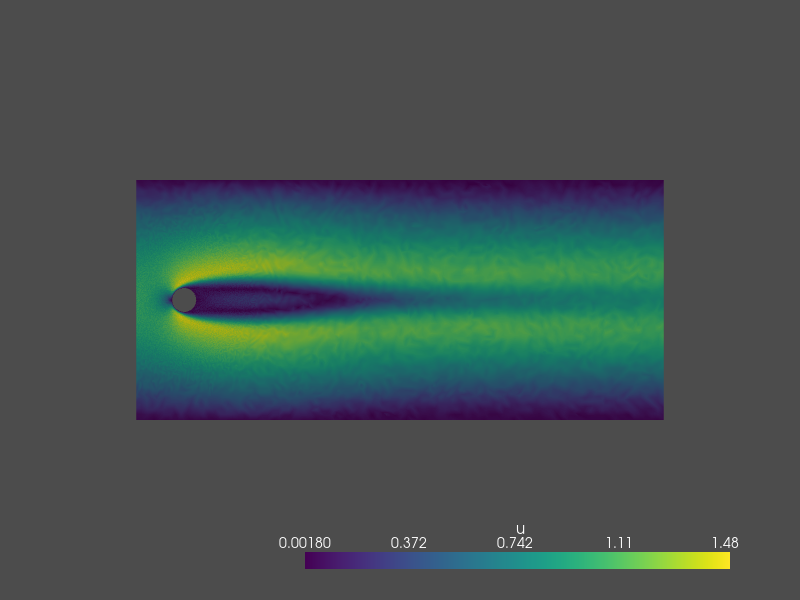

In [8]:
from pyvirtualdisplay import Display
import pyvista

display = Display(visible=0, size=(600, 400))
display.start()

(u_f, p_f) = (up.sub(0).collapse(), up.sub(1).collapse())

pyvista_cells, cell_types, coordinates = dolfinx.plot.create_vtk_mesh(u_f.function_space)
values = u_f.x.array.reshape(coordinates.shape[0], u_f.function_space.dofmap.index_map_bs)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
grid.point_data["u"] = values

plotter = pyvista.Plotter(notebook=True, window_size=(800,600))
plotter.add_mesh(grid)
plotter.camera_position = 'xy'
plotter.show()


Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(



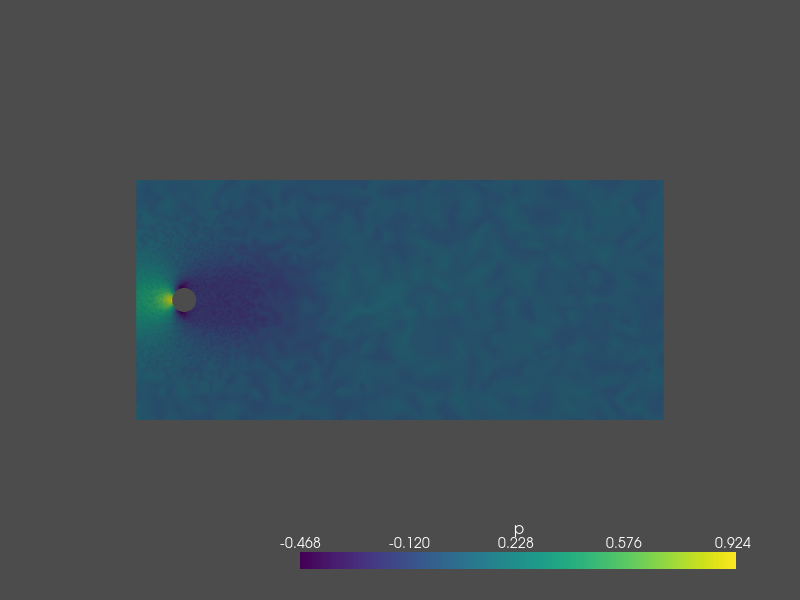

In [9]:

display = Display(visible=0, size=(600, 400))
display.start()

(u_f, p_f) = (up.sub(0).collapse(), up.sub(1).collapse())

pyvista_cells, cell_types, coordinates = dolfinx.plot.create_vtk_mesh(p_f.function_space)
values = p_f.x.array.reshape(coordinates.shape[0], p_f.function_space.dofmap.index_map_bs)
grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
grid.point_data["p"] = values

plotter = pyvista.Plotter(notebook=True, window_size=(800,600))
plotter.add_mesh(grid)
plotter.camera_position = 'xy'
plotter.show()

# Time dependant problem formulation

In [10]:
t = 0
T = 8 #8                    # Final time
dt = 1/1000              # Time step size
num_steps = int(T/dt)
k = Constant(mesh, PETSc.ScalarType(dt))  

## Formulation des equations 

### Navier stokes formumation forte :

$\begin{cases}
 & \frac{\partial u}{\partial t} + \left ( u \cdot \nabla  \right ) u \ - \nu \Delta u + \nabla p \ =  F \\
 & \triangledown \cdot u = 0
\end{cases}$

On exprime la derivée en temps par formule d'euler / difference finie

On choisie une formulation explicite pour le terme $\left ( u \cdot \nabla  \right ) u$ et implicite pour le terme de diffusion $\nu \Delta u$ par souci de convergence 

De plus nous avons pas de terme source donc F = 0

Ce qui donne :

$
\begin{cases}
 & \frac{u^{n+1} - u^{n}}{\Delta t} + \left ( u^{n} \cdot \nabla  \right ) u^{n} \ - \nu \Delta u^{n+1} + \nabla p^{n+1}  = \ 0 \\
 & \triangledown \cdot u^{n+1} = 0
\end{cases}
$

### Formulation faible :

$
\begin{cases} 
& \int_{\Omega }^{} \frac{u^{n+1} - u^{n}}{\Delta t} \cdot v \ d \Omega + \int_{\Omega }^{} \left [( u^{n} \cdot \nabla  \right ) u^{n}] \cdot v \ d \Omega \ - \int_{\Omega }^{} \nu \Delta u^{n+1} \cdot v \ d \Omega \ + \int_{\Omega }^{} \nabla p^{n+1}  \cdot v \ d \Omega \ = 0 \\ \\
& \int_{\Omega }^{} (\triangledown \cdot u^{n+1} \cdot q) \ d \Omega = 0
\end{cases}
\\
$

hors nous avons :

$
- \int_{\Omega }^{} \nu \Delta u^{n+1} \cdot v \ d \Omega \ = \int_{\Omega }^{} \nu \nabla u^{n+1} \cdot \nabla v) \ d \Omega \ - \int_{\partial \Omega }^{} \nu \frac{\partial u^{n+1}}{\partial n} \cdot v \ d \gamma
\\
$

et $
\int_{\Omega }^{} ( \nabla p^{n+1} \cdot v) \ d \Omega \ = - \int_{\Omega }^{} ( p^{n+1} \cdot div(v)) \ d \Omega \ + \int_{\partial \Omega }^{} pv \cdot n \ d \gamma
$

on obtient donc :

$
\begin{cases} 
& \int_{\Omega }^{} \frac{u^{n+1} - u^{n}}{\Delta t} \cdot v \ d \Omega + \int_{\Omega }^{} \left [( u^{n} \cdot \nabla  \right ) u^{n}] \cdot v \ d \Omega \ + \int_{\Omega }^{} \nu \nabla u^{n+1} \cdot \nabla v \ d \Omega \ - \int_{\Omega }^{} ( p^{n+1} \cdot div(v)) \ d \Omega \ = \int_{\partial \Omega }^{} (\nu \frac{\partial u^{n+1}}{\partial n} - pv) \cdot v \ d \gamma \\ \\
& \int_{\Omega }^{} (\triangledown \cdot u^{n+1} \cdot q) \ d \Omega = 0
\end{cases}
\\
$

Avec :

$
\int_{\partial \Omega }^{} (\nu \frac{\partial u^{n+1}}{\partial n} - pv) \cdot v \ d \gamma \ = \int_{\partial \Omega }^{} \psi \cdot v \ d \gamma \
$

finalement:

$
\int_{\Omega }^{} \frac{u^{n+1} - u^{n}}{\Delta t} \cdot v \ d \Omega + \int_{\Omega }^{} \left [( u^{n} \cdot \nabla  \right ) u^{n}] \cdot v \ d \Omega \ + \int_{\Omega }^{} \nu \nabla u^{n+1} \cdot \nabla v \ d \Omega \ - \int_{\Omega }^{} ( p^{n+1} \cdot div(v)) \ d \Omega \ + \int_{\Omega }^{} (\triangledown \cdot u^{n+1} \cdot q) \ d \Omega \ = 0
$

In [11]:

# Define functions for solutions at previous and current time steps
u_np_n = Function(W)
u_n,p_n = u_np_n.split()

with up.vector.localForm() as loc_u, u_np_n.vector.localForm() as loc_un:
    loc_u.copy(loc_un)

# Define expressions used in variational forms
k  = Constant(mesh, PETSc.ScalarType((dt)))

In [12]:
### directly solving navier stokes

F1 = ((1/k)*inner(u_n1 - u_n, v)*dx
    + inner(ufl.grad(u_n) * u_n, v) * dx 
    + nu * inner(ufl.grad(u_n1), ufl.grad(v)) * dx
    + inner(ufl.div(u_n1), q) * dx
    - inner(p_n1, ufl.div(v)) * dx)

## Assemblage des matrices 

$
\begin{cases} 
& \frac{u^{n+1} - u^{n}}{\Delta t} \cdot v + \left [( u^{n} \cdot \nabla  \right ) u^{n}] \cdot v \ \ + \nu \nabla u^{n+1} \cdot \nabla v \  -  p^{n+1} \cdot div(v)\ = F \\ \\
&(q  \cdot div(u^{n+1}) \ = 0
\end{cases}
\\
$

Lorsque l'on passe dans notre espace discretizé on obtient les expressions suivantes :

$\left [( u^{n} \cdot \nabla  \right ) u^{n}] \cdot v \ $ --> $L(U^{n})*U^{n}$

$\nu \nabla u^{n+1} \cdot \nabla v \ $--> $A*U^{n+1}$

$p^{n+1} \cdot div(v) \ $ --> $B^{T}*P^{n+1} $


$q  \cdot div(u^{n+1}) \ $ --> $B*U^{n+1} $

donc :

$
\begin{cases} 
& \frac{U^{n+1} - U^{n}}{\Delta t} + L(U^{n})*U^{n} \ + A*U^{n+1}  -  B^{T}*P^{n+1} = F \\ \\
& B*U^{n+1} = 0
\end{cases}
\\
$

hors on a $ W^{n+1} = \begin{bmatrix} U^{n+1} \\ P^{n+1} \end{bmatrix} $

si $ M = \begin{bmatrix}  I+A & B \\ B^{T} & 0 \end{bmatrix}$

et $ G^{n} = \begin{bmatrix} U^{n} - \Delta t ( L(U^{n})*U^{n} ) \end{bmatrix}$

alors 

$M W^{n+1} = G^{n} => W^{n+1} = M^{-1}G^{n} $




In [13]:
### assemblage des matrices 

a = form(lhs(F1))
L = form(rhs(F1))
A = assemble_matrix(a, bcs=bc)
A.assemble()
b = create_vector(L)  

print(A.getInfo())
print(A.isSymmetric())
print(A.size)

### parametres du solver 

solver1 = PETSc.KSP().create(mesh.comm)
solver1.setOperators(A)
solver1.setType("preonly")
solver1.setConvergenceHistory()
pc1 = solver1.getPC()
pc1.setType("lu")
# pc1.setFactorPivot(zeropivot=10e-10)
pc1.setFactorSolverType("mumps")


{'block_size': 1.0, 'nz_allocated': 2625930.0, 'nz_used': 2625930.0, 'nz_unneeded': 0.0, 'memory': 32817796.0, 'assemblies': 1.0, 'mallocs': 0.0, 'fill_ratio_given': 0.0, 'fill_ratio_needed': 0.0, 'factor_mallocs': 0.0}
False
(65168, 65168)


## Solving the time-dependent problem


In [14]:

# listes des solutions de taille nb pas de temps

list_u = []
list_p = []

### fonction utilisée pour la resolution du problème, Il est impossible d'utiliser les fonctions trials pour la resolution de pb non lineaire

up_temp =Function(W)

# bar de progression du calcul

progress = tqdm.notebook.tqdm(desc="Solving PDE", total=num_steps)

# boucle de resolution

for i in range(num_steps):
    progress.update(1)
    # Update current time step
    t += dt
    # Update inlet velocity
    inlet_velocity.t = t
    u_inlet.interpolate(inlet_velocity)
    
    # resolution
    with b.localForm() as loc:
        loc.set(0)
    assemble_vector(b, L)
    apply_lifting(b, [a], [bc])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, bc)
    solver1.solve(b, up_temp.vector)
    up_temp.x.scatter_forward()    
    
    
    # create solutions list for vtk plot
    
    if i%100 == 0 :
        (u_f, p_f) = (up_temp.sub(0).collapse(), up_temp.sub(1).collapse())
        list_u.append(u_f.copy())
        list_p.append(p_f.copy())
        
        if i%1000 == 0 :
        
            residual = A * up_temp.vector - b

            print( f"The relative residual is: {residual.norm() / b.norm()}." )

    # Update variable with solution form this time step
    with up_temp.vector.localForm() as loc_u, u_np_n.vector.localForm() as loc_un:
        loc_u.copy(loc_un)


Solving PDE:   0%|          | 0/8000 [00:00<?, ?it/s]

The relative residual is: 1.7246750677118573e-16.
The relative residual is: 1.68189651650333e-16.
The relative residual is: 1.6389054261081493e-16.
The relative residual is: 1.724065142415323e-16.
The relative residual is: 1.6784253250687087e-16.
The relative residual is: 1.7126436429026798e-16.
The relative residual is: 1.653164883430819e-16.
The relative residual is: 1.718505463369398e-16.


# Printing solutions 

In [15]:
!pip install vtk
!pip install pyvista
!pip install pyvirtualdisplay

In [16]:
import os, sys
import pyvista
import vtk
from vtk.util.misc import vtkGetDataRoot 

In [17]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(600, 400))
display.start()

plotter = pyvista.Plotter(notebook=True, window_size=(800,600))

plotter.open_gif("u_DNS_direct.gif")

progress = tqdm.notebook.tqdm(desc="creating Gif", total=len(list_u))

for i in list_u: 
    progress.update(1)
    pyvista_cells, cell_types, coordinates = dolfinx.plot.create_vtk_mesh(i.function_space)
    values = i.x.array.reshape(coordinates.shape[0], i.function_space.dofmap.index_map_bs)
    grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
    grid.point_data["u"] = values

    plotter.add_mesh(grid, clim=[0, 1.6], below_color='blue', above_color='yellow')
    plotter.camera_position = 'xy'
    plotter.render()
    plotter.write_frame()

# Closes and finalizes movie
plotter.close()

creating Gif:   0%|          | 0/80 [00:00<?, ?it/s]

![SegmentLocal](u_direct_iter.gif "segment")

In [18]:
display = Display(visible=0, size=(600, 400))
display.start()

plotter = pyvista.Plotter(notebook=True, window_size=(800,600))

plotter.open_gif("p_DNS_direct.gif")

progress = tqdm.notebook.tqdm(desc="creating Gif", total=len(list_u))

for i in list_p: 
    progress.update(1)
    pyvista_cells, cell_types, coordinates = dolfinx.plot.create_vtk_mesh(i.function_space)
    values = i.x.array.reshape(coordinates.shape[0], i.function_space.dofmap.index_map_bs)
    grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, coordinates)
    grid.point_data["p"] = values

    plotter.add_mesh(grid, clim=[-0.7, 1.1], below_color='blue', above_color='yellow')
    plotter.camera_position = 'xy'
    plotter.render()
    plotter.write_frame()

# Closes and finalizes movie
plotter.close()

creating Gif:   0%|          | 0/80 [00:00<?, ?it/s]

![SegmentLocal](p_direct_iter.gif "segment")